In [1]:
import torch
from torch import nn
from torch import optim
from torch.functional import F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

/Users/aronsajanphilip/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class WindowSizingDataset(Dataset):
    def __init__(self, training_dataset:pd.DataFrame):
        self.training_dataset = training_dataset
    
    def __len__(self):
        return self.training_dataset.shape[0]
    
    def __getitem__(self, index):
        input_data = torch.Tensor(dframe.iloc[index]['T1':'T4'].values.astype('float32'))
        output_data = dframe.iloc[index]['Window Size'].astype('float32')
        return input_data, output_data
    
    
    
dframe = pd.read_csv("./TrainingData.csv")
dataset = WindowSizingDataset(dframe)

win_size_dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)


In [3]:
for training_input, target_output in win_size_dataloader:
    print(training_input)
    

tensor([[8000., 8000., 8000., 8000.],
        [2700., 2700., 2700., 3200.],
        [3200.,  100., 3200.,  100.],
        [7500., 7700., 7000., 7200.],
        [4500., 5000., 5000., 6000.]])
tensor([[6500., 7000., 7000., 7000.],
        [7500., 8000., 8000., 7500.],
        [6500., 6000., 6000., 6300.],
        [6500., 7000., 7000., 6500.],
        [6500.,  300., 6500.,  300.]])
tensor([[4500., 4500., 4500., 4300.],
        [5300.,  200., 5300.,  200.],
        [3200., 3200., 3200., 3200.],
        [5500., 5300., 5300., 5000.],
        [5000.,  400., 5000.,  400.]])
tensor([[3000., 3000., 3000., 3000.],
        [3000., 3000., 3000., 2700.]])


In [ ]:
data_rate = [3000, 3000, 3000, #5000
             3000, 3000, 2700, #4700
             2700, 2700, 3200, #5100
             3200, 3200, 3200, #5200
             4500, 4500, 4300, #6200
             4500,5000,6000, #7400
             6500,7000,7000, #8800
             7500,8000,7500, #10000
             8000,8000,8000, #10000
             6500,6000,6300, #8500
             5500, 5300, 5000] #7100
window_size = [5000, 4700, 5100, 5200, 6200, 7400, 8800,10000,10000, 8500, 7100]

#data_rate_input = torch.Tensor(np.array(data_rate).reshape(-1,3,1))
data_rate_input = torch.Tensor(np.array(data_rate).reshape(-1,3))
target = torch.Tensor(np.array(window_size))
print(data_rate_input.shape)
print(target.shape)


In [4]:
class Network(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, 
                            hidden_size = hidden_size,
                            num_layers=1,
                            batch_first = True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)
    
    def forward(self, input_weights, hidden_weights):
        r_out, hidden = self.rnn(input_weights, hidden_weights)
        r_out = r_out[:,-1,:]
        out = self.fc(r_out)
        return out, hidden

device = torch.device("cpu")    
class SimpleNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features=4, out_features=3, device=device)
        self.fc2 = nn.Linear(in_features=3, out_features=1, device=device)
    
    def forward(self, input_wt):
        x = F.relu(self.fc1(input_wt))
        x = self.fc2(x)
        return x.cpu()
        
    

In [14]:

net = SimpleNet()
optimizer = optim.Adam(params=net.parameters(), lr=0.00001)
criterion = nn.MSELoss()

In [15]:

LOG_INTERVAL = 1000
net.train()
for epoch in range(0,12000):
    for training_input, target_output in win_size_dataloader:
        optimizer.zero_grad()
        prediction = net(training_input.to(device=device))
        loss = criterion(prediction.squeeze().to(device), target_output.to(device=device))
        loss.backward()
        optimizer.step()
    if(epoch%LOG_INTERVAL == 0):
        print("Epoch {}; Loss {}".format(epoch,loss.item()))

Epoch 0; Loss 109821832.0
Epoch 1000; Loss 94249416.0
Epoch 2000; Loss 43943360.0
Epoch 3000; Loss 15529350.0
Epoch 4000; Loss 36385952.0
Epoch 5000; Loss 9835620.0
Epoch 6000; Loss 23917540.0
Epoch 7000; Loss 25875250.0
Epoch 8000; Loss 6956475.5
Epoch 9000; Loss 8567496.0
Epoch 10000; Loss 2406669.0
Epoch 11000; Loss 881927.0625


In [19]:
torch.save(net.state_dict(), './temp.pt')

In [20]:
net.load_state_dict(torch.load("./window_size_model.pt"))

input_data = torch.Tensor(np.array([7000, 6000, 6900]).reshape(-1,3))
#print(data_rate_input)

tensor([[6500., 7000., 7000., 6500.],
        [5300.,  200., 5300.,  200.],
        [8000., 8000., 8000., 8000.],
        [5000.,  400., 5000.,  400.],
        [6500., 7000., 7000., 7000.]])


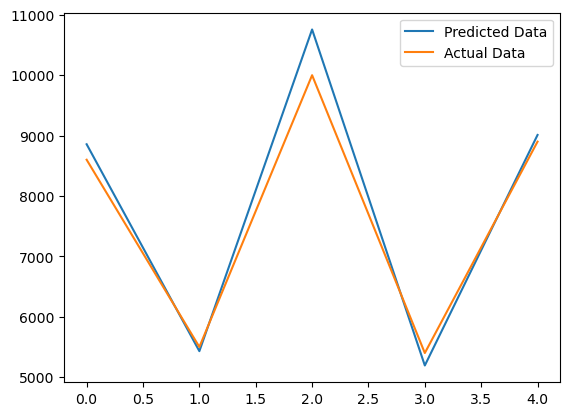

In [21]:
net.eval()

in_data, out_data = iter(win_size_dataloader).next()

out = net(in_data.to(device))
print(in_data)

plt.plot(range(0,len(out_data)), out.detach().numpy().squeeze(), label="Predicted Data")
plt.plot(range(0,len(out_data)), out_data.numpy(),  label='Actual Data')
plt.legend()

In [52]:
#torch.save(net.state_dict(), './window_size_model.pt')

1